In [1]:
import numpy as np
import tensorflow as tf
import gym
import time

In [2]:
def placeholder(dim=None):
    return tf.placeholder(dtype=tf.float32, shape=(None,dim) if dim else (None,))

def placeholders(*args):
    return [placeholder(dim) for dim in args]

def mlp(x, hidden_sizes=(32,), activation=tf.tanh, output_activation=None):
    for h in hidden_sizes[:-1]:
        x = tf.layers.dense(x, units=h, activation=activation)
    return tf.layers.dense(x, units=hidden_sizes[-1], activation=output_activation)

def get_vars(scope):
    return [x for x in tf.global_variables() if scope in x.name]

def count_vars(scope):
    v = get_vars(scope)
    return sum([np.prod(var.shape.as_list()) for var in v])

"""
Actor-Critics
"""
def mlp_actor_critic(x, a, x2, x_exp, a_exp, x2_exp, hidden_sizes=(400,300), activation=tf.nn.relu, 
                     output_activation=tf.tanh, action_space=None):
    act_dim = a.shape.as_list()[-1]
    act_limit = action_space.high[0]
    with tf.variable_scope('pi'):
        pi = act_limit * mlp(x, list(hidden_sizes)+[act_dim], activation, output_activation)
    with tf.variable_scope('q1'):
        q1 = tf.squeeze(mlp(tf.concat([x,a], axis=-1), list(hidden_sizes)+[1], activation, None), axis=1)
    with tf.variable_scope('q2'):
        q2 = tf.squeeze(mlp(tf.concat([x,a], axis=-1), list(hidden_sizes)+[1], activation, None), axis=1)
    with tf.variable_scope('q1', reuse=True):
        q1_pi = tf.squeeze(mlp(tf.concat([x,pi], axis=-1), list(hidden_sizes)+[1], activation, None), axis=1)
    
    df_mlp = lambda x : tf.squeeze(mlp(x, [100,100,1], tf.tanh, None), axis=1)
    with tf.variable_scope('th'):
        r = df_mlp(tf.concat([x,a,x2], axis=-1))
    with tf.variable_scope('th', reuse=True):
        r_exp = df_mlp(tf.concat([x_exp,a_exp,x2_exp], axis=-1))
    with tf.variable_scope('th', reuse=True):
        eps_x = tf.random_uniform(tf.shape(x), 0.0, 1.0)
        eps_a = tf.random_uniform(tf.shape(a), 0.0, 1.0)
        eps_x2 = tf.random_uniform(tf.shape(x2), 0.0, 1.0)
        x_eps = eps_x * x_exp + (1 - eps_x) * x
        a_eps = eps_a * a_exp + (1 - eps_a) * a
        x2_eps = eps_x2 * x2_exp + (1 - eps_x2) * x2
        
        d_input = tf.concat([x_eps,a_eps,x2_eps], axis=-1) 
        r_eps = df_mlp(d_input)
        gradients = tf.gradients(r_eps, d_input)[0]
        grad_l2 = tf.sqrt(tf.reduce_sum(tf.square(gradients),axis=-1))
        gp_loss = tf.reduce_mean(tf.square(grad_l2 - 1.0)) 
        
    return pi, q1, q2, q1_pi, r, r_exp, gp_loss

In [3]:
class ReplayBuffer:
    """
    A simple FIFO experience replay buffer for TD3 agents.
    """

    def __init__(self, obs_dim, act_dim, size):
        self.obs1_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.obs2_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size, act_dim], dtype=np.float32)
        self.rews_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs, done):
        
        self.obs1_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr+1) % self.max_size
        self.size = min(self.size+1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        return dict(obs1=self.obs1_buf[idxs],
                    obs2=self.obs2_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

env_name = 'Ant-v2'
env_fn = lambda : gym.make(env_name)
actor_critic=mlp_actor_critic
ac_kwargs=dict(hidden_sizes=[400, 300])
seed=0
steps_per_epoch=5000
epochs=200
replay_size=int(1e6)
total_exp_data_size=10000
exp_data_size=5000
gamma=0.99
polyak=0.995
th_lr=1e-3
th_lr_decay=1.
th_lr_schedule=100000 
pi_lr=1e-3
q_lr=1e-3
batch_size=100
start_steps=10000
act_noise=0.1
target_noise=0.2
noise_clip=0.5
policy_delay=2
disc_delay=1
max_ep_len=1000
save_freq=1

tf.set_random_seed(seed)
np.random.seed(seed)

env, test_env = env_fn(), env_fn()
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

# Action limit for clamping: critically, assumes all dimensions share the same bound!
act_limit = env.action_space.high[0]

# Share information about action space with policy architecture
ac_kwargs['action_space'] = env.action_space

# Inputs to computation graph
x_ph, a_ph, x2_ph, x_exp_ph, a_exp_ph, x2_exp_ph, r_ph, d_ph = placeholders(obs_dim, act_dim, obs_dim, obs_dim, act_dim, obs_dim, None, None)
th_lr_ph = tf.placeholder(dtype=tf.float32, shape=())

# Main outputs from computation graph
with tf.variable_scope('main'):
    pi, q1, q2, q1_pi, th, th_exp, gp_loss = actor_critic(x_ph, a_ph, x2_ph, x_exp_ph, a_exp_ph, x2_exp_ph, **ac_kwargs)

# Target policy network
with tf.variable_scope('target'):
    pi_targ, _, _, _, _, _, _  = actor_critic(x2_ph, a_ph, x2_ph, x_exp_ph, a_exp_ph, x2_exp_ph, **ac_kwargs)

# Target Q networks
with tf.variable_scope('target', reuse=True):

    # Target policy smoothing, by adding clipped noise to target actions
    epsilon = tf.random_normal(tf.shape(pi_targ), stddev=target_noise)
    epsilon = tf.clip_by_value(epsilon, -noise_clip, noise_clip)
    a2 = pi_targ + epsilon
    a2 = tf.clip_by_value(a2, -act_limit, act_limit)

    # Target Q-values, using action from target policy
    _, q1_targ, q2_targ, _, _, _, _ = actor_critic(x2_ph, a2, x2_ph, x_exp_ph, a_exp_ph, x2_exp_ph, **ac_kwargs)

# Experience buffer
replay_buffer = ReplayBuffer(obs_dim=obs_dim, act_dim=act_dim, size=replay_size)
exp_replay_buffer = ReplayBuffer(obs_dim=obs_dim, act_dim=act_dim, size=exp_data_size)

# Load Expert's Demos
exp_data_delay = 1#int(total_exp_data_size/exp_data_size)
demo_list = np.load('exp_'+env_name+'.npy')
for demo in demo_list:
    for t in range(len(demo['rew'])):
        if (t%exp_data_delay)==0:
            o = demo['obs'][t]
            a = demo['act'][t]
            r = demo['rew'][t]
            d = demo['done'][t]
            o2 = demo['obs'][t+1]
            exp_replay_buffer.store(o,a,r,o2,d)
        
        if exp_data_size < exp_replay_buffer.size:
            break
    if exp_data_size < exp_replay_buffer.size:
        break
        
# Count variables
var_counts = tuple(count_vars(scope) for scope in ['main/th', 'main/pi', 'main/q1', 'main/q2', 'main'])
print('\nNumber of parameters: \t th: %d, \t pi: %d, \t q1: %d, \t q2: %d, \t total: %d\n'%var_counts)

# Bellman backup for Q functions, using Clipped Double-Q targets

min_q_targ = tf.minimum(q1_targ, q2_targ)
r_backup = tf.log(tf.sigmoid(th)+1e-8) - tf.log(1-tf.sigmoid(th)+1e-8)
backup = tf.stop_gradient(r_backup + gamma*(1-d_ph)*min_q_targ)
# backup = tf.stop_gradient(r_backup + gamma*min_q_targ)

# TD3 losses
th_all = tf.concat([th,th_exp],axis=0)
probs_all = tf.sigmoid(th_all)
ent_th_loss = tf.reduce_mean(probs_all * tf.log(probs_all+1e-8) + (1-probs_all) * tf.log(1-probs_all+1e-8))

th_loss = - tf.reduce_mean(1-tf.log(tf.sigmoid(th)+1e-8)) - tf.reduce_mean(tf.log(tf.sigmoid(th_exp)+1e-8)) + 1e-3*ent_th_loss + 10.*gp_loss
gen_acc = tf.reduce_mean(tf.cast(tf.sigmoid(th) < 0.5, tf.float32))
exp_acc = tf.reduce_mean(tf.cast(tf.sigmoid(th_exp) > 0.5, tf.float32))

pi_loss = -tf.reduce_mean(q1_pi)
q1_loss = tf.reduce_mean((q1-backup)**2)
q2_loss = tf.reduce_mean((q2-backup)**2)
q_loss = q1_loss + q2_loss

th_optimizer = tf.train.AdamOptimizer(learning_rate=th_lr_ph)
train_th_op = th_optimizer.minimize(th_loss, var_list=get_vars('main/th'))

# Separate train ops for pi, q
pi_optimizer = tf.train.AdamOptimizer(learning_rate=pi_lr)
q_optimizer = tf.train.AdamOptimizer(learning_rate=q_lr)
train_pi_op = pi_optimizer.minimize(pi_loss, var_list=get_vars('main/pi'))
train_q_op = q_optimizer.minimize(q_loss, var_list=get_vars('main/q'))
    
# Polyak averaging for target variables
target_update = tf.group([tf.assign(v_targ, polyak*v_targ + (1-polyak)*v_main)
                          for v_main, v_targ in zip(get_vars('main'), get_vars('target'))])

q_step_ops = [q_loss, q1, q2, train_q_op]
pi_step_ops = [pi_loss, train_pi_op, target_update]
th_step_ops = [tf.reduce_mean(r_backup), th_loss, gen_acc, exp_acc, train_th_op]

# Initializing targets to match main variables
target_init = tf.group([tf.assign(v_targ, v_main)
                          for v_main, v_targ in zip(get_vars('main'), get_vars('target'))])

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
sess.run(target_init)

def get_action(o, noise_scale):
    a = sess.run(pi, feed_dict={x_ph: o.reshape(1,-1)})
#     a += noise_scale * np.random.randn(act_dim)
    return np.clip(a, -act_limit, act_limit)

def test_agent(n=10):
    ep_ret_list = []
    for j in range(n):
        o, r, d, ep_ret, ep_len = test_env.reset(), 0, False, 0, 0
        while not(d or (ep_len == max_ep_len)):
            # Take deterministic actions at test time (noise_scale=0)
            o, r, d, _ = test_env.step(get_action(o, 0))
            ep_ret += r
            ep_len += 1
        ep_ret_list.append(ep_ret)
    return ep_ret_list

start_time = time.time()
o, r, d, ep_ret, ep_len = env.reset(), 0, False, 0, 0
total_steps = steps_per_epoch * epochs

ep_ret_list = []

# Main loop: collect experience in env and update/log each epoch
for t in range(total_steps):
    if t > start_steps:
        a = get_action(o, act_noise)
    else:
        a = env.action_space.sample()

    # Step the env
    o2, r, d, _ = env.step(a)
    ep_ret += r
    ep_len += 1

    # Ignore the "done" signal if it comes from hitting the time
    # horizon (that is, when it's an artificial terminal signal
    # that isn't based on the agent's state)
    d = False if ep_len==max_ep_len else d

    replay_buffer.store(o, a, r, o2, d)

    # Super critical, easy to overlook step: make sure to update 
    # most recent observation!
    o = o2

    if d or (ep_len == max_ep_len):
        for j in range(ep_len):
            batch_exp = exp_replay_buffer.sample_batch(batch_size)
            batch = replay_buffer.sample_batch(batch_size)
            feed_dict = {x_ph: batch['obs1'],
                         x2_ph: batch['obs2'],
                         a_ph: batch['acts'],
                         x_exp_ph: batch_exp['obs1'],
                         x2_exp_ph: batch_exp['obs2'],
                         a_exp_ph: batch_exp['acts'],
                         d_ph: batch['done'], 
                         th_lr_ph: th_lr
                        }
            outs = sess.run(q_step_ops, feed_dict)

            if j % policy_delay == 0:
                # Delayed policy update
                outs = sess.run(pi_step_ops, feed_dict)
            if j % disc_delay == 0:
                th_outs = sess.run(th_step_ops, feed_dict)

        o, r, d, ep_ret, ep_len = env.reset(), 0, False, 0, 0
    
    if t > 0 and t % th_lr_schedule == 0:
        th_lr *= th_lr_decay
    
    # End of epoch wrap-up
    if t > 0 and t % steps_per_epoch == 0:
        epoch = t // steps_per_epoch
        # Test the performance of the deterministic version of the agent.
        test_ep_ret = test_agent()
        ep_ret_list.append(np.mean(test_ep_ret))
        print('Test Ret:%f'%np.mean(test_ep_ret))
        print(th_outs[0],th_outs[1],th_outs[2],th_outs[3])


Number of parameters: 	 th: 33301, 	 pi: 167508, 	 q1: 168601, 	 q2: 168601, 	 total: 538011

Test Ret:-0.390865
-17.743784 -17.634575 1.0 0.82
Test Ret:-65.854493
-18.209974 -17.661104 1.0 0.9
Test Ret:-26.301430
-18.095007 -18.489635 1.0 0.87
Test Ret:-85.043822
-17.976686 -17.988602 1.0 0.89
Test Ret:-42.652156
-18.330988 -18.263577 1.0 0.87
Test Ret:-160.061644
-17.026283 -15.815888 1.0 0.63
Test Ret:-107.871881
-18.08942 -18.268126 1.0 0.92
Test Ret:-120.785463
-17.868206 -17.211445 1.0 0.93
Test Ret:-39.460070
-17.436783 -17.376553 1.0 0.8
Test Ret:-151.663410
-18.204355 -17.201084 1.0 0.66
Test Ret:-96.585189
-18.252893 -18.542944 1.0 0.92
Test Ret:-339.252318
-18.288754 -18.236162 1.0 0.93
Test Ret:-219.159141
-16.63134 -15.415244 1.0 0.62
Test Ret:-204.107650
-17.95558 -16.598362 1.0 0.9
Test Ret:-271.104401
-18.191473 -18.207771 1.0 0.84
Test Ret:-238.123591
-18.248472 -18.52236 1.0 0.91
Test Ret:-206.451451
-18.31337 -18.190659 1.0 0.91
Test Ret:-83.169082
-17.37298 -17.250

Test Ret:-201.040989
-17.534534 -16.845238 1.0 0.72
Test Ret:-118.714946
-15.821794 -13.866917 1.0 0.45
Test Ret:-498.542374
-17.696943 -16.2876 1.0 0.73
Test Ret:-87.636607
-17.115139 -16.105679 1.0 0.68
Test Ret:-192.982557
-17.683388 -16.83081 1.0 0.75
Test Ret:-193.049840
-17.794077 -16.03704 1.0 0.79
Test Ret:-123.544512
-17.839098 -16.55226 1.0 0.73
Test Ret:-202.264463
-17.941515 -16.857603 1.0 0.76
Test Ret:-162.396314
-18.146969 -17.199442 1.0 0.87
Test Ret:-377.368747
-18.014612 -17.038595 1.0 0.78
Test Ret:-84.678756
-17.783579 -16.638323 1.0 0.79
Test Ret:-359.228897
-16.910713 -16.108267 1.0 0.66
Test Ret:-196.429012
-17.998787 102.27309 1.0 0.84
Test Ret:-42.191297
-17.94255 -17.546146 1.0 0.87
Test Ret:-146.907400
-17.190536 -16.506851 1.0 0.79
Test Ret:-207.780244
-16.578224 -14.331042 1.0 0.59
Test Ret:-225.019577
-17.802814 -13.868345 1.0 0.86
Test Ret:-355.326231
-17.538946 -16.470644 1.0 0.74
Test Ret:-237.965357
-17.196959 -15.570332 1.0 0.63
Test Ret:-334.171983
-

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

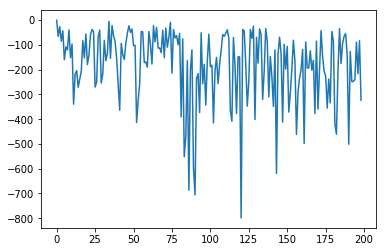

In [5]:
plt.plot(ep_ret_list)